**Student Name**:    Mark Rotchell

**Student Number**:	  13181875

**Module Title**: 	     Applied Machine Learning

**Assignment Type**:  Individual Practical Project



# **Detecting Impersonation Attacks in the Public AWID Dataset Using Cardinality-Tiered Encoding and a Supervised Stacked Auto Encoder**

## Upgrade and import libraries

In [1]:
# This code requires sci-kit learn 0.24 or better
!pip install --upgrade scikit-learn

     |████████████████████████████████| 22.2MB 1.9MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
# Base libraries
import numpy as np
import pandas as pd
import random as rn
import keras
import tensorflow as tf

In [3]:
# Keras API for neural networks
from keras import layers
from keras.models import Sequential
from keras import regularizers

In [6]:
# High-level classes
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone

# Processing and selecting
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, StandardScaler, Binarizer, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest, chi2, RFE
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate

# Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix, roc_auc_score, brier_score_loss, plot_roc_curve

In [7]:
# Classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree

In [73]:
# Data visualisation
import plotly.express as px
import seaborn as sns

In [9]:
# Set a seed for reproducibility 

my_seed = 3141592653 # first 10 digits of pi
                     
np.random.seed(my_seed)
rn.seed(my_seed)
tf.random.set_seed(my_seed)
tf.compat.v1.set_random_seed(my_seed)

## Import data and do basic prep

In [10]:
# Change to whereever you have your input datasets stored
root_directory = '/content/drive/MyDrive/AML Data/'

The names.txt file can be downloaded from: https://drive.google.com/file/d/10a_9W5lKBDAMcqu3v3-e294Asr0L-vfT/view?usp=sharing

In [11]:
# Get Feature Names From File
with open(root_directory + 'names.txt', 'r') as input_file:
    all_names = [line.strip('\n') for line in input_file.readlines()]

In [12]:
# Load Data Sets
train_file = 'train_imperson_without4n7_balanced_data.csv'
test_file = 'test_imperson_without4n7_balanced_data.csv'

df = pd.read_csv(root_directory + train_file, names=all_names, header=0)
df_test = pd.read_csv(root_directory + test_file, names=all_names, header=0)

In [14]:
# Impact paper suggests an extra temporal column - remove that. 
# Also wlan_seq appears to be temporal (in an ordinal sense) - also removing that
for data_frame in [df, df_test]:
  data_frame.drop(columns=['radiotap_mactime', 'wlan_seq'], inplace=True)

In [15]:
# extract remaining feature names
feature_names = df.columns[:-1]
feature_names

Index(['frame_interface_id', 'frame_dlt', 'frame_offset_shift',
       'frame_time_delta', 'frame_time_delta_displayed', 'frame_len',
       'frame_cap_len', 'frame_marked', 'frame_ignored', 'radiotap_version',
       ...
       'wlan_qos_tid', 'wlan_qos_priority', 'wlan_qos_eosp', 'wlan_qos_ack',
       'wlan_qos_amsdupresent', 'wlan_qos_buf_state_indicated',
       'wlan_qos_bit4', 'wlan_qos_txop_dur_req',
       'wlan_qos_buf_state_indicated_2', 'data_len'],
      dtype='object', length=150)

In [16]:
# Transfer to numpy arrays
def split_df_to_X_and_Y(data_frame):
  return data_frame.values[:,:-1], data_frame.values[:,-1]
  
X, Y = split_df_to_X_and_Y(df)
X_test, Y_test = split_df_to_X_and_Y(df_test)

## Helper functions for model evaluation

In [17]:
metric_names = ['acc', 'rec', 'pre', 'far', 'fnr', 'f1', 'mcc', 'roc']

def metric_summary(y_true, y_prediction, y_probability):
  # return a list of model evaluation metrics give a vector of actual values, 
  # and  a vector of predicted values. Each vector bound to {0,1}
  acc = accuracy_score(y_true, y_prediction)
  rec = recall_score(y_true, y_prediction, zero_division=0)
  pre = precision_score(y_true, y_prediction, zero_division=0)
  cm = confusion_matrix(y_true, y_prediction)
  far = cm[0,1]/cm[0].sum()
  fnr = cm[1,0]/cm[1].sum()
  f1 = f1_score(y_true, y_prediction, zero_division=0)
  mcc = 0
  mcc = matthews_corrcoef(y_true, y_prediction)  
  roc = roc_auc_score(y_true, y_probability)
  return np.array([acc, rec, pre, far, fnr, f1, mcc, roc])

def print_metric_summary(fitted_model, x_validate, y_validate):
    predictions = fitted_model.predict(x_validate)
    probabilities = fitted_model.predict_proba(x_validate)[:,1]
    metrics = metric_summary(y_validate, predictions, probabilities)
    for name, metric in zip(metric_names, metrics):
      print(name, metric*100, sep='\t')



## Data Pre-processing

### Cardinality-tiered encoder, subclassed from base transformer

In [18]:
class DataEncoder(TransformerMixin, BaseEstimator):
    # Estimator for encoding of Binary and Categeorical Features.
    # Features with 2 unique values in the training data get 
    # binarized to {0,1}. Novel features get 1
    # 
    # Features with (2 < n < one_hot_below_n)  unique values get one-hot-encoded.
    # Novel features get 0 for all one-hot features
    # 
    # Features with (one_hot_below_n <= n < categorical_below_n) get
    # ordinal encoded

    def __init__(self, one_hot_below_n = 5, categorical_below_n=20):
        self.categorical_below_n = categorical_below_n
        self.one_hot_below_n = one_hot_below_n

        self.binary_support = []
        self.one_hot_support = []
        self.categorical_support = []
        self.continuous_support = []

        self.binarize_transformer = Binarizer()
        self.one_hot_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)
        self.ordinal_transformer = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
        

    def fit(self, X, Y=None):
        nuniques=np.apply_along_axis(lambda a: len(np.unique(a)), 0, X)

        self.binary_support = [i for i, x in enumerate(nuniques) if x ==2]
        self.one_hot_support = [i for i, x in enumerate(nuniques) if 2 < x < 5]
        self.categorical_support = [i for i, x in enumerate(nuniques) if 5 <= x < self.categorical_below_n]
        self.continuous_support = [i for i, x in enumerate(nuniques) if x >= self.categorical_below_n]

        self.binarize_transformer.fit(X[:,self.binary_support])
        self.one_hot_transformer.fit(X[:, self.one_hot_support])
        self.ordinal_transformer.fit(X[:, self.categorical_support])

        return self

    def transform(self, X, Y=None):
        def unknowns_to_max_plus_one(a):
          a[a==-1]=max(a)+1
          return a      
        
        X_bin = self.binarize_transformer.transform(X[:,self.binary_support])
        X_ohe = self.one_hot_transformer.transform(X[:,self.one_hot_support])
        X_cat = np.apply_along_axis(unknowns_to_max_plus_one, 0, self.ordinal_transformer.transform(X[:, self.categorical_support]))
        X_con = X[:, self.continuous_support]

        return np.hstack([X_bin, X_ohe, X_cat, X_con])

### Apply pre-processing to create cross-validation and full/test data sets, and extract names of remaining features

In [21]:
# Pipeline for data preparation before any machine learning
prep_pipeline_estimators = []
prep_pipeline_estimators.append(( 'var_threshold', VarianceThreshold()))
prep_pipeline_estimators.append(( 'data_encode', DataEncoder()))
prep_pipeline_estimators.append(( 'scaler', StandardScaler()))
prep_pipeline = Pipeline(prep_pipeline_estimators)

In [22]:
# prepare cross-validation data sets once so that they don't need to be 
# repeatedly created. Also prepare the full data set and test set
# From here on the following naming system is used for data sets:
#
# train    := the training portion of data set (either cv fold or the full data set)
# validate := the validation portion of data set (either cv fold or the full data set)
# full     := the whole training data set
# test     := the whole testing set

N_SPLITS = 5

k_fold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=my_seed)

validation_sets = []
for train_indices, validate_indices in k_fold.split(X, Y):
    prep_pipe = clone(prep_pipeline)
    x_train, x_validate = X[train_indices], X[validate_indices]
    x_train, x_validate = prep_pipe.fit_transform(x_train), prep_pipe.transform(x_validate)
    y_train, y_validate = Y[train_indices], Y[validate_indices]
    validation_sets.append((x_train, x_validate, y_train, y_validate))

# prepare the full data set and test set
prep_pipe = clone(prep_pipeline)
x_prep_full, x_prep_test = prep_pipe.fit_transform(X), prep_pipe.transform(X_test)

cv_and_test_sets = validation_sets[:]
cv_and_test_sets.append((x_prep_full, x_prep_test, Y, Y_test))

In [23]:
# get remaining features from pipe
VT_support = prep_pipe.named_steps['var_threshold'].get_support()
bin_support = prep_pipe.named_steps['data_encode'].binary_support
ohe_support = prep_pipe.named_steps['data_encode'].one_hot_support
ohe_categories = prep_pipe.named_steps['data_encode'].one_hot_transformer.categories_
cat_support = prep_pipe.named_steps['data_encode'].categorical_support
con_support = prep_pipe.named_steps['data_encode'].continuous_support

feature_names_after_VT = feature_names[VT_support]
bin_features = list(feature_names_after_VT[bin_support])
ohe_features = []
for feature, categories in zip(feature_names_after_VT[ohe_support], ohe_categories):
    for category in categories:
      ohe_features.append(feature + '|' + str(round(category, 5)))

cat_features = list(feature_names_after_VT[cat_support])
con_features = list(feature_names_after_VT[con_support])

features_after_data_encoding = [*bin_features, *ohe_features, *cat_features, *con_features ]

## Simple Model Exploration

In [24]:
# Simple models before Feature Extraction
classifiers = []
classifiers.append((  'DT  ', DecisionTreeClassifier(random_state=my_seed)  ))
classifiers.append((  'RF  ', RandomForestClassifier(random_state=my_seed)  ))
classifiers.append((  'LDA ', LinearDiscriminantAnalysis()  ))
classifiers.append((  'LR  ', LogisticRegression(max_iter=10000, random_state=my_seed)  ))
classifiers.append((  'AB  ', AdaBoostClassifier(random_state=my_seed)  ))

print('model','cv_acc', '\t\ttest_acc', sep='\t')
benckmark_model_results = dict()
for name, classifier in classifiers:
    cv_results = []
    for x_train, x_validate, y_train, y_validate in validation_sets:
      score = clone(classifier).fit(x_train, y_train).score(x_validate, y_validate)
      cv_results.append(score)
    cv_result = np.mean(cv_results)
    test_result = clone(classifier).fit(x_prep_full, Y).score(x_prep_test, Y_test)

    benckmark_model_results[name] = (cv_result, test_result)
    print(name, cv_result,test_result, sep='\t')

model	cv_acc			test_acc
DT  	0.999330201264344	0.7239902385576971
RF  	0.9997011669058095	0.5361820807809153
LDA 	0.9851922793400721	0.9765924597838538
LR  	0.991478088903861	0.8952139050749539
AB  	0.9997732994530842	0.9949947706559091


In [51]:
# Tuning of Adaboost - search for best n_estimators
results = []
for x_train, x_validate, y_train, y_validate in cv_and_test_sets:
    ABC = AdaBoostClassifier(n_estimators=200, random_state=my_seed)
    ABC.fit(x_train, y_train)
    results.append([*ABC.staged_score(x_validate, y_validate)])

# ABC = AdaBoostClassifier(n_estimators=200, random_state=my_seed)
# ABC.fit(x_prep_full, Y)
cv_results = np.mean(results[:-1], axis=0)
test_results = results[-1]

# cross validation and test accuracy for each n_estimator
print('n stumps', 'cv_acc', '', '',  'test_acc', sep='\t')
for i, (cv_mean, test) in enumerate(zip(cv_results,test_results)):
  print(i+1, '', cv_mean, test, sep='\t')

n stumps	cv_acc			test_acc
1		0.9311755544093844	0.8973305443498182
2		0.9464882044930585	0.7357438119428258
3		0.9515065374521139	0.9493251655958962
4		0.978813752125515	0.7676179092584292
5		0.9779481472228169	0.9607799193186912
6		0.9883145979565917	0.7741919418297724
7		0.9891286347088195	0.9699935255739828
8		0.991962400305788	0.9718860501020967
9		0.9925806839850475	0.97333034513671
10		0.9948064778338399	0.9809751481647493
11		0.9961357724000607	0.9421783953384133
12		0.9963418623583274	0.9432740674336372
13		0.9964036946552148	0.985581951292395
14		0.9972074550493888	0.9865033119179242
15		0.9974547693705977	0.9451914936002789
16		0.9980524318423937	0.9454903132626127
17		0.9984130924550051	0.9443448378903332
18		0.998444005948745	0.946785198466059
19		0.9984336972033058	0.9449673788535286
20		0.9986707033100162	0.9464863788037253
21		0.9988767991086313	0.9923800986104886
22		0.9991344104945832	0.992454803526072
23		0.999041674260889	0.9916828527317098
24		0.999361114758084	0.9

In [52]:
# get metrics for best simple model

best_n_stumps = np.argmax(cv_results)+1
best_CV_accuracy = np.max(cv_results)
print(f'Best CV performance with {best_n_stumps} stumps giving mean {best_CV_accuracy*100} CV accuracy')

simple_model = AdaBoostClassifier(n_estimators=best_n_stumps, random_state=my_seed)
simple_model.fit(x_prep_full, Y)
print('\nTest Data Metric Summary')
print_metric_summary(simple_model,x_prep_test,Y_test)

Best CV performance with 190 stumps giving mean 99.98248230045326 CV accuracy

Test Data Metric Summary
acc	99.82568853030529
rec	99.93525573982768
pre	99.71674203647567
far	0.2838786792170925
fnr	0.06474426017231934
f1	99.82587930948709
mcc	99.65161632389852
roc	99.98759494349628


In [53]:
features_used_by_adaboost = [i for i, x in enumerate(simple_model.feature_importances_) if x>0]
print(f'There were {len(features_used_by_adaboost)} features used by adaboost, they were:')
for feature in features_used_by_adaboost:
  print(features_after_data_encoding[feature])

There were 27 features used by adaboost, they were:
wlan_fc_retry
wlan_fc_pwrmgt
wlan_fc_moredata
wlan_mgt_fixed_capabilities_preamble
wlan_mgt_fixed_status_code
wlan_mgt_fixed_beacon
wlan_mgt_fixed_auth_alg
wlan_mgt_fixed_aid|0.16667
wlan_mgt_fixed_auth_seq|0.25
wlan_mgt_fixed_auth_seq|1.0
radiotap_datarate
wlan_fc_subtype
frame_time_delta
frame_time_delta_displayed
frame_len
frame_cap_len
radiotap_dbm_antsignal
wlan_fc_type_subtype
wlan_ra
wlan_da
wlan_ta
wlan_sa
wlan_mgt_fixed_timestamp
wlan_mgt_ssid
wlan_wep_iv
wlan_wep_icv
data_len


## Extended Model using Deep Feature extraction and advanced Selection Techniques

### Supervised Stacked Auto Encoder class to be used in pipelining

In [19]:
class SupervisedStackedAutoEncoder(TransformerMixin, BaseEstimator):
    # A supervised stacked autoencoder is similar to a stacked auto encoder, but
    # has two outputs providing loss to train the model. 
    #  - The first outpout is the standard auto-encoder output, which is compared 
    #    against the input data with the goal of it being recreated from the 
    #    latent space
    #
    #  - The second output is a classification output, allowing the latent space
    #    to also be tailored towards being useful for classification, not just as
    #    a dimensionally reduced form of the input


    def __init__(self, n_components, batch_size, epochs, sparsity, learning_rate, random_state):
        self.n_components = n_components
        self.batch_size = batch_size
        self.epochs = epochs
        self.random_state = random_state
        self.activation = 'tanh' # chosen to give nice distribution of values in latent layer       
        self.initializer = keras.initializers.glorot_normal(seed=self.random_state)
        self.sparsity = sparsity
        self.regularizer = regularizers.l2(self.sparsity)
        self.learning_rate = learning_rate
        self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=self.learning_rate)
        self.loss_weights = [0.5, 0.5] # Equal importance

        self.training_model = None
        self.transforming_model = None
    
    def fit(self, X, Y, verbose=0, x_validate=None, y_validate=None):
        input_dim = X.shape[1]
        hidden_dim = (input_dim + self.n_components) //2

        # helper inner function for standard layer creation
        def layer(dim, name, activation=self.activation):
            return layers.Dense(dim, activation=activation, 
                                kernel_initializer=self.initializer, 
                                activity_regularizer=self.regularizer, 
                                name=name)

        # layers for SSAE
        input_layer = keras.Input(shape=(input_dim,), name='input_layer')
        encode_layer = layer(hidden_dim,'encode_layer')(input_layer)
        latent_layer = layer(self.n_components,'latent_layer')(encode_layer)
        decode_layer = layer(hidden_dim,'decode_layer')(latent_layer)
        autoencode_output = layer(input_dim, 'autoencode_output', activation='linear')(decode_layer) # linear activation to allow to take values from wider range given input is ~ Norm(0,1)
        classify_output = layer(1, 'classify_output')(latent_layer)

        # training model including outputs for training the representaion layer
        self.training_model = keras.Model(inputs=input_layer, 
                                          outputs=[classify_output, autoencode_output], 
                                          name='training_model')
        

        # transforming model ending at the representation layer to be used to produce 
        # extracted features once the model has been trained
        self.transforming_model = keras.Model(inputs=input_layer, 
                                              outputs=latent_layer, 
                                              name='transforming_model')

        
        # Compile model, using different loss functions for the regression task and 
        # the classification task
        self.training_model.compile(optimizer=self.optimizer,
                                    loss={"classify_output": keras.losses.BinaryCrossentropy(),
                                          "autoencode_output": tf.keras.losses.MeanAbsoluteError()},
                                    metrics={"classify_output": 'accuracy'},
                                    loss_weights=self.loss_weights)
        

        # Allow for validation data if providede, and fit model. the autoencoder part is trained on the input (i.e. X),
        # whilst the classification part is trained on the target class (i.e. Y)
        if x_validate is None or y_validate is None:
            self.training_model.fit(X, {"classify_output": Y, "autoencode_output": X}, epochs=self.epochs, batch_size=self.batch_size, verbose=verbose)
        else:
            self.training_model.fit(X, {"classify_output": Y, "autoencode_output": X}, epochs=self.epochs, batch_size=self.batch_size, verbose=verbose, 
                                    validation_data = (x_validate, {"classify_output": y_validate, "autoencode_output": x_validate}))
        return self
    
    def transform(self, X, Y=None):

        return self.transforming_model.predict(X)
    
    def plot_model(self, path):

        keras.utils.plot_model(self.training_model, path, show_shapes=True)


### cross validation for SSAE hyper_parameters

In [ ]:

# initially use 64 epochs, but provide keras with the validataion
# data set so the accuracy at all epochs can be seen in the history
# For this purpose the accuracy metric for the classification output is used.
#
# Some hyper parameters have been chosen by hand or through previous manual
# trial-and-error not captured in this final code. Testing all possible
# combinations was not possible in the time. They are:
#
#  - Use of tanh as an activation function:
#         Allows the latent later to take values in the range {-1, 1} with a
#         reasonably smooth distribution. Using relu caused them to bunch
#         around zero
#
#  - Use of RMSprop and L2 regulariztion. Both found to be better than 
#         alternatives during early manual investigation, not captured here.
#
#  - Choice of a single layer between the in/output and the latent layer:
#         Somewhat arbitrary choice. Kept shallow to avoid overfitting
#         and speed up fitting. The number of nodes was again arbitrarily 
#         chosen as the average of the input and latent layers. Alternative
#         hidden layer sizes have not been explored.
#
#  - Choice of 20 nodes in the latent layer:
#         The ability of AdaBoost to get > 99% accuracy with just 27 dimensions
#         Suggested that 20 was more than enough to capture the information
#         necessary for high accuracy. 

# validate using a hold out set. Full cross validation will just take too long
x_train, x_validate, y_train, y_validate = train_test_split(x_prep_full, Y, test_size=0.2, random_state=my_seed)
SSAE_hyper_parameter_results = dict()
for batch_size in [512, 1024, 2048]:
    for sparsity in [0.000001, 0.00001, 0.0001]:
        for learning_rate in [0.001, 0.0001, 0.00001]:

            # build template SSAE model
            SSAE = SupervisedStackedAutoEncoder(n_components=20, batch_size = batch_size,
                                                epochs = 64, random_state=my_seed, learning_rate=learning_rate,
                                                sparsity=sparsity)
            
            model = clone(SSAE)
            model.fit(x_train, y_train, verbose=0, x_validate=x_validate, y_validate=y_validate)
            cv_curve = model.training_model.history.history['val_classify_output_accuracy']

            model = clone(SSAE)
            model.fit(x_prep_full, Y, verbose=0, x_validate=x_prep_test, y_validate=Y_test)
            test_curve = model.training_model.history.history['val_classify_output_accuracy']

            for epochs in [4,8,16,32,64]:
                print(batch_size, epochs, sparsity, learning_rate, cv_curve[epochs-1]*100, test_curve[epochs-1]*100, sep='\t')

            SSAE_hyper_parameter_results[(batch_size, sparsity, learning_rate)] = (cv_curve, test_curve)


#batch  epoch  sparsity LR      validation acc          test acc

512	4	1e-06	0.001	99.23231601715088	99.36251640319824
512	8	1e-06	0.001	99.60842728614807	99.81074929237366
512	16	1e-06	0.001	99.79391098022461	99.8779833316803
512	32	1e-06	0.001	99.85573887825012	99.90288615226746
512	64	1e-06	0.001	99.90726113319397	99.91782307624817
512	4	1e-06	0.0001	98.63465428352356	98.63787889480591
512	8	1e-06	0.0001	99.08289909362793	98.63290190696716
512	16	1e-06	0.0001	99.2632269859314	98.95662069320679
512	32	1e-06	0.0001	99.38688278198242	99.62647557258606
512	64	1e-06	0.0001	99.68571066856384	99.82568621635437
512	4	1e-06	1e-05	50.1004695892334	93.95886063575745
512	8	1e-06	1e-05	61.12627983093262	95.95597386360168
512	16	1e-06	1e-05	98.39249849319458	97.98296689987183
512	32	1e-06	1e-05	98.64495992660522	98.40380549430847
512	64	1e-06	1e-05	99.05198812484741	97.79371619224548
512	4	1e-05	0.001	99.21170473098755	99.30275678634644
512	8	1e-05	0.001	99.65994954109192	99.78335499763489
512	16	1e-05	0.001	99.75269436836243	99.87050890922546
512	32	1e-05	0.0

In [26]:
# hyper parameters chosen :
best_batch_size = 512
best_learning_rate = 1e-3
best_sparsity = 1e-6
best_epochs = 64

### Prepare cross-validation and full/test data sets for features selection, including all 128 features

In [27]:
# Pipeline before features selection
pre_FS_pipeline_estimators = []
pre_FS_pipeline_estimators.append(( 'var_threshold', VarianceThreshold()))
pre_FS_pipeline_estimators.append(( 'data_encode', DataEncoder()))
pre_FS_pipeline_estimators.append(( 'scaler', StandardScaler()))

feature_union_estimators = []
feature_union_estimators.append(( 'autoencoder', 
                             SupervisedStackedAutoEncoder(n_components=20, batch_size = best_batch_size,
                                                          epochs = best_epochs, random_state=my_seed, 
                                                          learning_rate=best_learning_rate, sparsity=best_sparsity) ))
feature_union_estimators.append(( 'pass_through', FunctionTransformer() ))

pre_FS_pipeline_estimators.append(( 'feature_extraction', FeatureUnion(feature_union_estimators) ))
pre_FS_pipeline = Pipeline(pre_FS_pipeline_estimators)

In [28]:
# create validation and full data sets upto feature selection

N_SPLITS = 5

pre_FS_cv_and_test_sets = []

for train_indices, validate_indices in StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=my_seed).split(X, Y):
    pipe = clone(pre_FS_pipeline)
    x_train, x_validate = X[train_indices], X[validate_indices]
    y_train, y_validate = Y[train_indices], Y[validate_indices]
    x_train, x_validate = pipe.fit_transform(x_train, y_train), pipe.transform(x_validate)
    pre_FS_cv_and_test_sets.append((x_train, x_validate, y_train, y_validate))

# prepare the full data set and test set
pipe = clone(pre_FS_pipeline)
x_pre_FS_full, x_pre_FS_test = pipe.fit_transform(X, Y), pipe.transform(X_test)

# pre_FS_cv_and_test_sets = validation_sets[:]
pre_FS_cv_and_test_sets.append((x_pre_FS_full, x_pre_FS_test, Y, Y_test))

#### Helper class for Chi-squared on non-positive data

In [20]:
class Chi_Squared_Filter_Non_Positive(TransformerMixin, BaseEstimator):
    # chi squared requires positive inputs, so here
    # the input X data are first scaled to [0,1] using a min-max scaler
    # and this scaled X is used for input into chi2
    # note that the transform step does not rescale the data
    # so the original scale is kept when transform is called.

    def __init__(self, k):
      self.k=k
      self.select_k_best = SelectKBest(score_func=chi2, k=self.k)
      
    def fit(self, X, y):
      self.select_k_best.fit(MinMaxScaler().fit_transform(X), y)
      
      return self

    # def get_support(self, index=False):
      
    #   return self.select_k_best.get_support(index)

    def transform(self, X, y=None):
      return self.select_k_best.transform(X)

#### Two Feature-Selection Models explored, using three techniques (wrapper, filter, embedded)

In [29]:
feature_selection_models = dict()

for n_features in [2, 3]:
    # filter with chi_squared followed by Log Reg RFE
    feature_selection_models[f'LR {n_features} '] = \
      make_pipeline(Chi_Squared_Filter_Non_Positive(k=20),
                    RFE(LogisticRegression(max_iter=10000), 
                        n_features_to_select=n_features, step=5))
      
    # Adaboost embedded filter
    feature_selection_models[f'AB {n_features} '] = \
      SelectFromModel(estimator=AdaBoostClassifier(n_estimators=50, 
                                                  random_state=my_seed), 
                                                  threshold=1e-5, max_features=n_features)

### Apply feature selection and prepare cross-validation and full/test data sets for classifier selection

In [30]:
# use feature selectors to reduce validation and full/test data sets
# the max "fold" is the full/test data sets, the others are cross-validation sets
pre_classification_sets = dict()
for fs_name, fs_model in feature_selection_models.items():
    for fold, (x_train, x_validate, y_train, y_validate) in enumerate(pre_FS_cv_and_test_sets):
        model = clone(fs_model)
        x_fs, x_fs_v = model.fit_transform(x_train, y_train), model.transform(x_validate)
        key = (fs_name, fold)
        data = (x_fs, x_fs_v, y_train, y_validate)
        pre_classification_sets[key] = data
        print(*key)


LR 2  0
LR 2  1
LR 2  2
LR 2  3
LR 2  4
LR 2  5
AB 2  0
AB 2  1
AB 2  2
AB 2  3
AB 2  4
AB 2  5
LR 3  0
LR 3  1
LR 3  2
LR 3  3
LR 3  4
LR 3  5
AB 3  0
AB 3  1
AB 3  2
AB 3  3
AB 3  4
AB 3  5


### Choose combination of feature selector, number of features, and classifier using cross-validation

In [31]:
classifiers = dict()
classifiers['RC  '] = RidgeClassifier()
classifiers['KNN3'] = KNeighborsClassifier(n_neighbors=3)
classifiers['KNN5'] = KNeighborsClassifier(n_neighbors=5)
classifiers['KNN7'] = KNeighborsClassifier(n_neighbors=7)
classifiers['LR  '] = LogisticRegression(max_iter=50000)
classifiers['LDA '] = LinearDiscriminantAnalysis()
classifiers['QDA '] = QuadraticDiscriminantAnalysis()
classifiers['SVM1'] = make_pipeline(StandardScaler(), LinearSVC(max_iter=5000, C=1))
classifiers['SVM2'] = make_pipeline(StandardScaler(), LinearSVC(max_iter=5000, C=0.1))
classifiers['SVM3'] = make_pipeline(StandardScaler(), LinearSVC(max_iter=5000, C=0.01))
classifiers['SVM4'] = make_pipeline(StandardScaler(), SVC(max_iter=5000, C=1, kernel='rbf'))
classifiers['SVM5'] = make_pipeline(StandardScaler(), SVC(max_iter=5000, C=0.1, kernel='rbf'))
classifiers['SVM6'] = make_pipeline(StandardScaler(), SVC(max_iter=5000, C=0.01, kernel='rbf'))
classifiers['NB  '] = BernoulliNB()
classifiers['AB10'] = AdaBoostClassifier(n_estimators=10)
classifiers['AB25'] = AdaBoostClassifier(n_estimators=25)
classifiers['AB50'] = AdaBoostClassifier(n_estimators=50)

In [32]:
# final cross validation to choose feature selector and and classifier
print('FS K', 'Classf', 'CV acc', '','','test acc', sep='\t')
for feature_selection_name in feature_selection_models.keys():
    for clf_name, clf_model in classifiers.items():
        results = []
        for fold in range(N_SPLITS+1):
            key = (feature_selection_name, fold)
            x_train, x_validate, y_train, y_validate = pre_classification_sets[key]
            score = clone(clf_model).fit(x_train, y_train).score(x_validate, y_validate)
            results.append(score)
        cv_score = np.mean(results[:-1])
        test_score = results[-1]
        
        print(feature_selection_name, clf_name, cv_score*100, test_score*100, sep='\t')

FS K	Classf	CV acc			test acc
LR 2 	RC  	90.53839260111566	99.87051147965536
LR 2 	KNN3	99.7052905101733	99.91782459285821
LR 2 	KNN5	99.69189434432153	99.920314756711
LR 2 	KNN7	99.68365079908492	99.90288360974152
LR 2 	LR  	94.43969005888219	99.88296229891927
LR 2 	LDA 	90.53839260111566	99.87051147965536
LR 2 	QDA 	92.40661230201593	99.88794262662483
LR 2 	SVM1	94.0821240343834	99.87051147965536
LR 2 	SVM2	93.99041400295467	99.86802131580258
LR 2 	SVM3	93.79256743064225	99.86304098809701


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


LR 2 	SVM4	96.00803533151536	99.8779819712137


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


LR 2 	SVM5	91.305062218397	99.86802131580258


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


LR 2 	SVM6	90.78880639509205	99.83066885801087
LR 2 	NB  	89.38739489125422	99.53682952338264
LR 2 	AB10	99.08598546020902	53.16748842073808
LR 2 	AB25	99.21582298342229	54.03406544150605
LR 2 	AB50	99.46725501555294	53.8248916778724
AB 2 	RC  	82.00824539291037	79.47606952537477
AB 2 	KNN3	99.17048637824803	51.120573733751684
AB 2 	KNN5	99.13235947049832	51.006026196523734
AB 2 	KNN7	99.06950182085066	53.23721300861597
AB 2 	LR  	82.09794337130467	79.62298919268888
AB 2 	LDA 	82.00824539291037	79.47606952537477
AB 2 	QDA 	86.07442267521333	79.45116788684695


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


AB 2 	SVM1	82.25969675128404	79.48852034463869


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


AB 2 	SVM2	82.26072725416944	79.48852034463869
AB 2 	SVM3	82.24423931419108	79.48852034463869


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_

AB 2 	SVM4	86.8307720256413	77.09796304596843


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_

AB 2 	SVM5	80.84900881009088	54.28806215448977


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_

AB 2 	SVM6	76.06741223984912	48.737486926639775
AB 2 	NB  	85.10785678888654	78.960605607849
AB 2 	AB10	95.74728374964113	87.67119876487874
AB 2 	AB25	96.44493080504166	85.40763982270033
AB 2 	AB50	97.17139833268466	86.47342995169082
LR 3 	RC  	92.95068899542912	99.88296229891927
LR 3 	KNN3	99.88252803356497	99.91533442900543
LR 3 	KNN5	99.86397961875652	99.91782459285821
LR 3 	KNN7	99.85573607351992	99.91533442900543
LR 3 	LR  	96.78808545189662	99.88296229891927
LR 3 	LDA 	92.95068899542912	99.88296229891927


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


LR 3 	QDA 	90.97325706702304	99.89790328203595
LR 3 	SVM1	96.68607097564865	99.88545246277205
LR 3 	SVM2	96.66030973086528	99.88545246277205
LR 3 	SVM3	96.17290644862359	99.88296229891927


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


LR 3 	SVM4	99.35081477316704	99.91035410129987


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


LR 3 	SVM5	99.12205460092645	99.90039344588874


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


LR 3 	SVM6	94.9415193196381	99.86802131580258
LR 3 	NB  	93.15471964693545	95.00971163902585
LR 3 	AB10	99.15399514643705	99.36251805368794
LR 3 	AB25	99.46416239192118	53.964340853628165
LR 3 	AB50	99.59193890936362	53.97430150903929
AB 3 	RC  	85.92807639914459	92.295433039494
AB 3 	KNN3	99.60739809856103	83.50515463917526
AB 3 	KNN5	99.56205814846012	85.2109168783306
AB 3 	KNN7	99.512596505382	86.17710045320982
AB 3 	LR  	87.13169681397751	97.91822301907466
AB 3 	LDA 	85.92601549956193	92.295433039494
AB 3 	QDA 	92.26541301859052	98.74495741819813


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


AB 3 	SVM1	87.31508273734528	97.74391154937994


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


AB 3 	SVM2	87.30271718056703	97.74391154937994
AB 3 	SVM3	87.29859527521356	97.72648040241047


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AB 3 	SVM4	97.8618132318673	98.59305742317844


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


AB 3 	SVM5	94.3407457474726	97.30813287514319


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_

AB 3 	SVM6	92.36125159213199	96.740375516709
AB 3 	NB  	85.29952045007464	94.74824443448378
AB 3 	AB10	98.35642345064164	98.15229842123611
AB 3 	AB25	98.69029167845532	98.51586234374223
AB 3 	AB50	98.86340910169201	98.7748393844315


# **Best model = 3 features, Chi2 filter + Log Reg RFE, K-Nearest Neighbours with 3 features**


## Final Extended Model

In [34]:
# Final Best Model Pipeline

final_pipeline_estimators = []
final_pipeline_estimators.append(( 'var_threshold', VarianceThreshold()))
final_pipeline_estimators.append(( 'data_encode', DataEncoder()))
final_pipeline_estimators.append(( 'scaler', StandardScaler()))

final_pipeline_feature_union_estimators = []
final_pipeline_feature_union_estimators.append(( 'autoencoder', 
                             SupervisedStackedAutoEncoder(n_components=20, batch_size = best_batch_size,
                                                          epochs = best_epochs, random_state=my_seed, 
                                                          learning_rate=best_learning_rate, sparsity=best_sparsity) ))
final_pipeline_feature_union_estimators.append(( 'pass_through', FunctionTransformer() ))

final_pipeline_estimators.append(( 'feature_extraction', FeatureUnion(final_pipeline_feature_union_estimators) ))
final_pipeline_estimators.append(( 'feature_selection',   make_pipeline(Chi_Squared_Filter_Non_Positive(k=20), RFE(LogisticRegression(max_iter=10000), n_features_to_select=3, step=5)) ))
final_pipeline_estimators.append(( 'classification', KNeighborsClassifier(n_neighbors=3)))

final_pipeline = Pipeline(final_pipeline_estimators)

final_pipeline.fit(X, Y)
final_pipeline.score(X_test, Y_test)

0.9991533442900543

In [46]:
print_metric_summary(final_pipeline, X_test, Y_test)

acc	99.91533442900543
rec	99.98007868917774
pre	99.8507833872171
far	0.14940983116689077
fnr	0.019921310822252104
f1	99.91538920963568
mcc	99.83075255253951
roc	99.87839569633014


In [45]:
# Get Final Feature Names
features_before_selection = np.array([f'extracted_feature_{i}' for i in range(1,21)] + features_after_data_encoding)
filter_support = final_pipeline.named_steps['feature_selection'].named_steps['chi_squared_filter_non_positive'].select_k_best.get_support()
wrapper_support = final_pipeline.named_steps['feature_selection'].named_steps['rfe'].get_support()
final_features = features_before_selection[filter_support][wrapper_support]
final_features

array(['extracted_feature_3', 'extracted_feature_8',
       'extracted_feature_14'], dtype='<U46')

## Results Visualisation

In [72]:
final_df = pd.DataFrame(x_pre_FS_full[:,[2,7,13]], columns=final_features)
final_df['class'] = Y.astype(str)
fig = px.scatter_3d(final_df, x='extracted_feature_3', y='extracted_feature_8', z='extracted_feature_14', color='class')
fig.update_traces(marker=dict(size=3, line=dict(width=0.01, color='DarkSlateGrey')), selector=dict(mode='markers'))
fig.show()

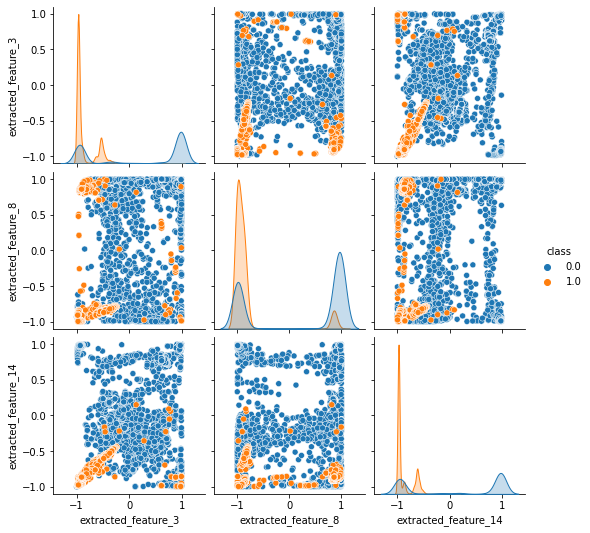

In [74]:
sns.pairplot(final_df, hue='class')

## Evaluation of the models piecewise to understand the benefit of each contribution

In [ ]:
# Get full data sets again
df_AB_eval = pd.read_csv(root_directory + train_file, names=all_names, header=0)
df_test_AB_eval = pd.read_csv(root_directory + test_file, names=all_names, header=0)
X_AB_eval, Y_AB_eval = split_df_to_X_and_Y(df_AB_eval)
X_test_AB_eval, Y_test_AB_eval = split_df_to_X_and_Y(df_test_AB_eval)

In [ ]:
def check_accuracy_on_model(model, x_eval, y_eval, x_test_eval, y_test_eval):
  print('Cross Validation Summary')
  cv = cross_validate(model, x_eval, y_eval, cv=k_fold, scoring=['accuracy','recall','precision','f1'])
  for key, value in cv.items():
    if key[:4]=='test':
      print(key[5:].ljust(10), np.mean(value)*100, sep='\t')

  model.fit(x_eval, y_eval)
  print('\nTest Summary')
  print_metric_summary(model, x_test_eval, y_test_eval)

In [ ]:
# check accuracy on data set with no pre processing
model = AdaBoostClassifier(n_estimators=190, random_state=my_seed)

check_accuracy_on_model(model, X_AB_eval, Y_AB_eval, X_test_AB_eval, Y_test_AB_eval)


Cross Validation Summary
accuracy  	99.99793910041733
recall    	99.99793899422919
precision 	99.99793941891613
f1        	99.99793910039546

Test Summary
acc	98.12490661885552
rec	99.84560984112754
pre	96.52383245064998
far	3.5957966034165048
fnr	0.15439015887245383
f1	98.15662562119023
mcc	96.30685958019778
roc	98.88186421838826


In [ ]:
# check accuracy on data set with temporal features kept, but with zero-variance features removed, then standard scaling, and encoding
model = make_pipeline(VarianceThreshold(), StandardScaler(), DataEncoder(), AdaBoostClassifier(n_estimators=190, random_state=my_seed))

check_accuracy_on_model(model, X_AB_eval, Y_AB_eval, X_test_AB_eval, Y_test_AB_eval)

Cross Validation Summary
accuracy  	99.99793910041733
recall    	99.99793899422919
precision 	99.99793941891613
f1        	99.99793910039546

Test Summary
acc	99.38990985606853
rec	99.42228198615469
pre	99.35795341429424
far	0.6424622740176303
fnr	0.577718013845311
f1	99.39010729132957
mcc	98.77984041550093
roc	99.56420929598617


In [ ]:
# check accuracy on data set with temporal features removed but no other pre-processing
model = AdaBoostClassifier(n_estimators=190, random_state=my_seed)

check_accuracy_on_model(model, X, Y, X_test, Y_test)

Cross Validation Summary
accuracy  	99.97836039509977
recall    	99.97526856784627
precision 	99.98145328250618
f1        	99.97835949196435

Test Summary
acc	97.24587877882365
rec	94.72085263210319
pre	99.75872016784683
far	0.22909507445589922
fnr	5.279147367896807
f1	97.17453505007153
mcc	94.61247981323993
roc	99.95912579396744


In [ ]:
# check accuracy on data set with temporal- and zero-variance- features removed, standard scaling, but no encoding
model = make_pipeline(VarianceThreshold(), StandardScaler(), AdaBoostClassifier(n_estimators=190, random_state=my_seed))

check_accuracy_on_model(model, X, Y, X_test, Y_test)

Cross Validation Summary
accuracy  	99.97733005149658
recall    	99.97732957361708
precision 	99.97733360702735
f1        	99.97733042273387

Test Summary
acc	97.64679515912147
rec	95.53762637581553
pre	99.74521630615641
far	0.24403605757258828
fnr	4.462373624184472
f1	97.59609269670068
mcc	95.378488116721
roc	99.95891645104284


In [ ]:
# check accuracy on data set with temporal- and zero-variance- features removed, standard scaling, and encoding
model = make_pipeline(VarianceThreshold(), StandardScaler(), DataEncoder(), AdaBoostClassifier(n_estimators=190, random_state=my_seed))

check_accuracy_on_model(model, X, Y, X_test, Y_test)

Cross Validation Summary
accuracy  	99.98248230045326
recall    	99.98145158515872
precision 	99.98351386472788
f1        	99.98248224722242

Test Summary
acc	99.82568853030529
rec	99.93525573982768
pre	99.71674203647567
far	0.2838786792170925
fnr	0.06474426017231934
f1	99.82587930948709
mcc	99.65161632389852
roc	99.98759494349628
